# Library

In [ ]:
# === Standard Libraries ===
import os
import json
import random
import shutil

# === Data Handling & Computation ===
import numpy as np
import pandas as pd

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

# === Progress Bar ===
from tqdm.notebook import tqdm as tq

# === Image Processing (OpenCV & skimage) ===
import cv2
from skimage import io, img_as_ubyte
from skimage.io import imread
from skimage.exposure import adjust_gamma
from skimage.transform import rotate, warp, AffineTransform
from skimage.util import random_noise
from collections import Counter

# === TensorFlow & Keras ===
import tensorflow as tf
from tensorflow.keras import Sequential as KerasSeq
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# === Scikit-learn ===
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

2025-06-11 05:38:04.402900: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749620284.588800      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749620284.644402      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load data

In [ ]:
src = "/kaggle/input/garbage-classification/Garbage classification/Garbage classification"
dst = "/kaggle/working/dataset"

shutil.copytree(src, dst, dirs_exist_ok=True)

'/kaggle/working/dataset'

# Data understanding

## Menampilkan sampel data tiap kelas / kategori

Folder: cardboard


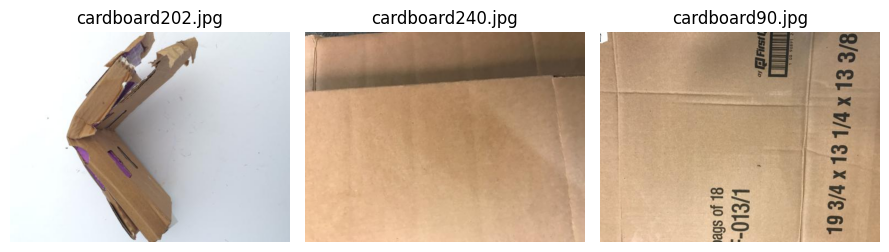

Folder: glass


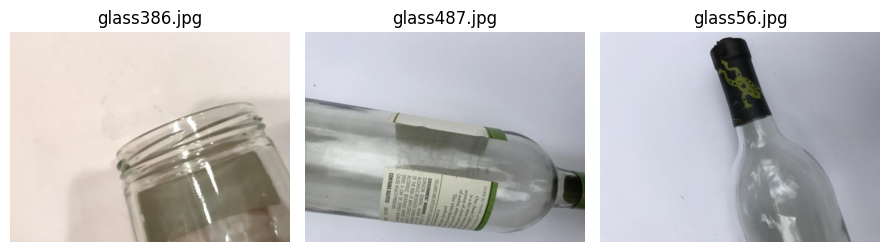

Folder: metal


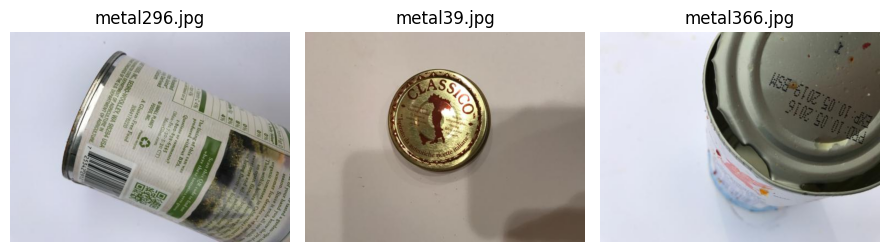

Folder: paper


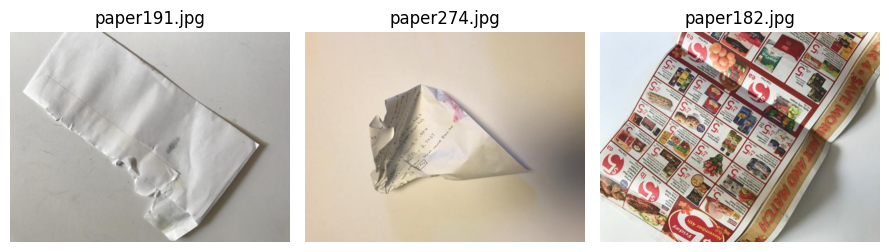

Folder: plastic


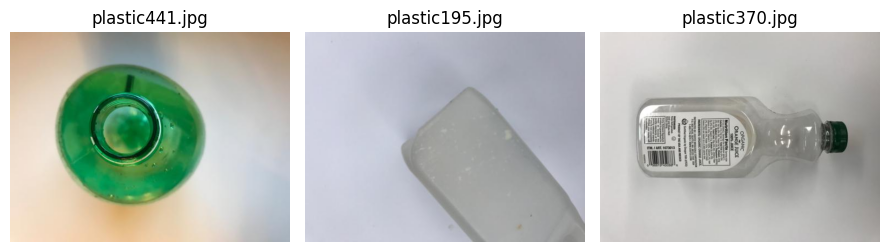

Folder: trash


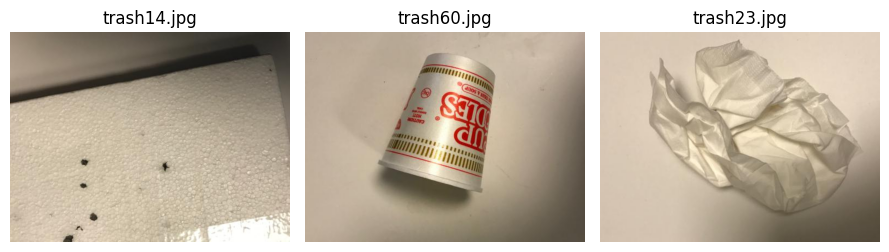

In [ ]:
base_path = "/kaggle/working/dataset"
folders = sorted(os.listdir(base_path))

for folder in folders:
    folder_path = os.path.join(base_path, folder)
    if not os.path.isdir(folder_path):
        continue

    images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:3]

    print(f"Folder: {folder}")
    plt.figure(figsize=(9, 3))
    for i, img_name in enumerate(images):
        img_path = os.path.join(folder_path, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.title(f"{img_name}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

## Menampilkan jumlah data tiap kelas / kategori

In [ ]:
mypath= '/kaggle/working/dataset'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
df.groupby(['labels']).size()

labels
cardboard    403
glass        501
metal        410
paper        594
plastic      482
trash        137
dtype: int64

## Menampilkan spesifikasi gambar / file setiap sampel data

In [ ]:
base_path = "/kaggle/working/dataset"
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']

image_sizes = []

for root, dirs, files in os.walk(base_path):
    for file in files:
        if any(file.lower().endswith(ext) for ext in image_extensions):
            file_path = os.path.join(root, file)
            try:
                img = cv2.imread(file_path)
                if img is not None:
                    height, width = img.shape[:2]
                    image_sizes.append((height, width))
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

size_counts = Counter(image_sizes)

print("Daftar ukuran gambar dan jumlahnya:\n")
for size, count in size_counts.items():
    print(f"Ukuran {size[0]}x{size[1]} → {count} gambar")

Daftar ukuran gambar dan jumlahnya:

Ukuran 384x512 → 2527 gambar


## Kesimpulan data understanding

Setelah serangkaian tahapan pada data understanding dapat disimpulkan bahwa:
* Dataset yang dipakai memiliki 6 kelas atau kategori
* Tiap kelas memiliki jumlah sampel data hampir seimbang kecuali kelas "trash"
* Kelas "trash" memiliki sampel data yang beragam dan terdapat gambar yang seharusnya masuk dalam kelas / kategori lainnya
* Seluruh gambar atau file memiliki ukuran gambar yang seragam

# Data Preparation

## Menghapus subfolder kelas "trash"

In [ ]:
folder_to_remove = "/kaggle/working/dataset/trash"

shutil.rmtree(folder_to_remove, ignore_errors=True)

df = df[~df["path"].str.startswith(folder_to_remove)].reset_index(drop=True)

## Data split

In [ ]:
X= df['path']
y= df['labels']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

print('train size', len(df_tr))
print('test size', len(df_te))

train size 1912
test size 478


### Menampilkan jumlah sampel data setelah data split

In [ ]:
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print(df_all.groupby(['set', 'labels']).size(), '\n')

set    labels   
test   cardboard     85
       glass         90
       metal         85
       paper        130
       plastic       88
train  cardboard    318
       glass        411
       metal        325
       paper        464
       plastic      394
dtype: int64 



### Menyalin data ke folder baru setelah data split

In [ ]:
datasource_path = "/kaggle/working/dataset"
dataset_path = "/kaggle/working/dataset-final"

for index, row in tq(df_all.iterrows()):
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

### Menampilkan jumlah sampel data tiap kelas / kategori setelah data split

In [ ]:
TRAIN_DIR = "/kaggle/working/dataset-final/train/"
TEST_DIR = "/kaggle/working/dataset-final/test/"

classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic']

for cls in classes:
    train_path = os.path.join(TRAIN_DIR, cls)
    test_path = os.path.join(TEST_DIR, cls)

    print(f"Total number of images in training set ({cls}):", len(os.listdir(train_path)))
    print(f"Total number of images in test set ({cls}):", len(os.listdir(test_path)))

Total number of images in training set (cardboard): 318
Total number of images in test set (cardboard): 85
Total number of images in training set (glass): 411
Total number of images in test set (glass): 90
Total number of images in training set (metal): 325
Total number of images in test set (metal): 85
Total number of images in training set (paper): 464
Total number of images in test set (paper): 130
Total number of images in training set (plastic): 394
Total number of images in test set (plastic): 88


## Inisiasi data generator

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(256, 256),
    batch_size=32,
    color_mode="rgb",
    class_mode='sparse',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(256, 256),
    batch_size=32,
    color_mode="rgb",
    class_mode='sparse',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(256, 256),
    batch_size=32,
    color_mode="rgb",
    class_mode='sparse',
    shuffle=False
)

Found 1532 images belonging to 5 classes.
Found 380 images belonging to 5 classes.
Found 478 images belonging to 5 classes.


## Kesimpulan data preparation

Setelah serangkaian tahapan pada data preparation dapat disimpulkan bahwa:
* Kelas/kategori "trash" sudah berhasil dihapus atau tidak diikut sertakan dalam proses melatih model
* Dataset telah melalui tahapan data split dengan menggunakan method train_test_split dengan ketentuan pembagian data train dan tes (rasio tes 0.2)
* Jumlah sampel data pada data train sebanyak 1912 dan data test sebanyak 478
* Sebelum melatih model langkah selanutnya adalah mempersiapkan data image untuk proses pelatihan (training), validasi (validation), dan pengujian (testing) model deep learning menggunakan Keras
* Menyisihkan sebanyak 20 persen data train sebagai data validasi
* Menetapkan beberapa parameter seperti target_size (256x256), batch_size (32), color_mode (rgb), class_mode (sparse), shuffle (pada data train bernilai "true")

# Model

## Tuning

In [ ]:
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
train_labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(num_classes),
    y=train_labels
)

class_weights_dict = dict(enumerate(class_weights))
print("\nClass weights:", class_weights_dict)

priority_boost = {
    1: 1.5,  # glass
    2: 1.5,  # metal
}

for cls_idx, boost in priority_boost.items():
    class_weights_dict[cls_idx] *= boost

print("\n")

for cls_idx, weight in class_weights_dict.items():
    class_name = class_names[cls_idx]
    print(f"{class_name:8s} (class {cls_idx}): {weight:.4f}")


Class weights: {0: 1.2015686274509805, 1: 0.931306990881459, 2: 1.1784615384615384, 3: 0.8236559139784946, 4: 0.9696202531645569}


cardboard (class 0): 1.2016
glass    (class 1): 1.3970
metal    (class 2): 1.7677
paper    (class 3): 0.8237
plastic  (class 4): 0.9696


## Inisiasi model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1749620320.584899      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      29,491,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,585,989 (112.86 MB)

 Trainable params: 29,585,989 (112.86 MB)

 Non-trainable params: 0 (0.00 B)

## Melatih model

In [ ]:
classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic']
class_indices = {cls: i for i, cls in enumerate(classes)}

counts = [len(os.listdir(os.path.join(TRAIN_DIR, cls))) for cls in classes]
total_samples = sum(counts)

labels = []
for idx, count in enumerate(counts):
    labels.extend([idx] * count)
labels = np.array(labels)

class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

print("Class weights:", class_weights)

%time

early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True,
    mode="max",
    verbose=1
)

history = model.fit(
    train_generator,
    epochs=30,
    batch_size=32,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Class weights: {0: 1.2025157232704402, 1: 0.9304136253041363, 2: 1.1766153846153846, 3: 0.8241379310344827, 4: 0.9705583756345177}
CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.11 µs
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1749620324.795234     119 service.cc:148] XLA service 0x7f523800c680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749620324.796243     119 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749620325.123828     119 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/48 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.2465 - loss: 3.5470

I0000 00:00:1749620330.589840     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 237ms/step - accuracy: 0.2357 - loss: 2.5742 - val_accuracy: 0.3474 - val_loss: 1.4769
Epoch 2/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.4450 - loss: 1.2978 - val_accuracy: 0.3921 - val_loss: 1.3968
Epoch 3/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.5249 - loss: 1.1652 - val_accuracy: 0.4605 - val_loss: 1.2752
Epoch 4/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.5965 - loss: 0.9745 - val_accuracy: 0.4842 - val_loss: 1.2524
Epoch 5/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.6521 - loss: 0.8818 - val_accuracy: 0.5237 - val_loss: 1.1850
Epoch 6/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.6906 - loss: 0.7601 - val_accuracy: 0.5184 - val_loss: 1.2473
Epoch 7/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.7404 - loss: 0.7054 - val_accuracy: 0.4974 - val_loss: 1.1986
Epoch 8/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.7777 - loss: 0.5954 - val_accuracy: 0.5526 - val_loss: 

## Kesimpulan model

Pada tahapan model terdapat beberapa aktivitas sebelum dan saat melatih model sehingga dapat disimpulkan bahwa:
* Sebelum melatih model kelas "glass" dan "metal" dilakukan priority boost
* Selanjutnya inisiasi model dengan menggunakan CNN untuk klasifikasi 5 kelas, 3 blok konvlusi + pooling, beberapa dropout, 1 output layer softmax 5 kelas
* Model dilatih dengan menjaga keseimbangan tiap kelas, melatih model dengan menggunakan data generator, menerapkan early stopping untuk efisiensi dan generalisasi yang lebih baik

# Evaluasi

## Visualisasi performa model

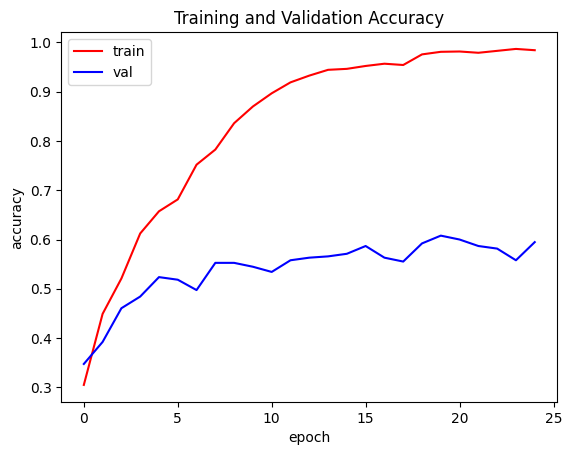

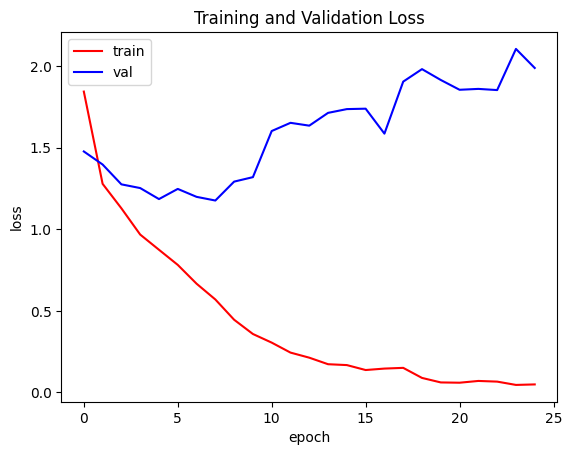

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

## Menampilkan performa akhir dengan menggunakan data uji

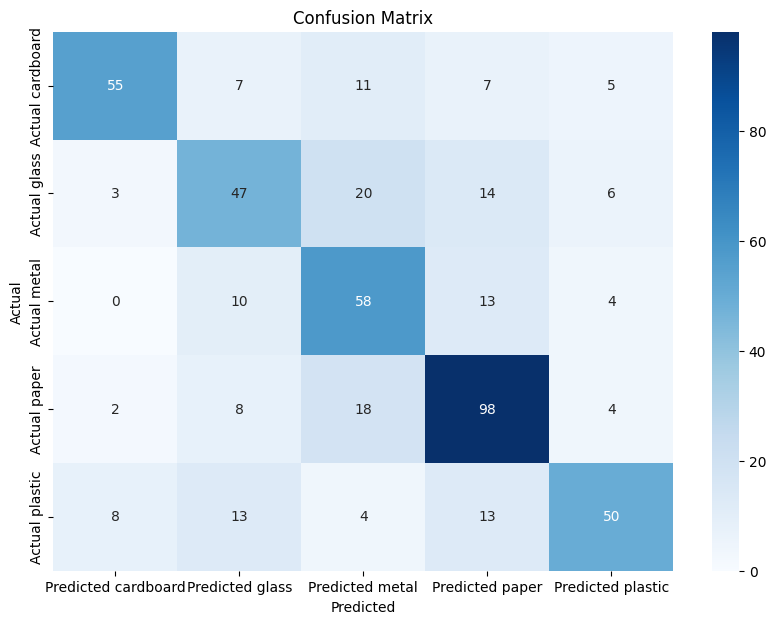


Classification Report:

              precision    recall  f1-score   support

   cardboard     0.8088    0.6471    0.7190        85
       glass     0.5529    0.5222    0.5371        90
       metal     0.5225    0.6824    0.5918        85
       paper     0.6759    0.7538    0.7127       130
     plastic     0.7246    0.5682    0.6369        88

    accuracy                         0.6444       478
   macro avg     0.6570    0.6347    0.6395       478
weighted avg     0.6581    0.6444    0.6453       478



In [ ]:
test_generator.reset()

preds = model.predict(test_generator, verbose=0)
pred_classes = np.argmax(preds, axis=1)

true_classes = test_generator.classes

class_names = list(test_generator.class_indices.keys())

cm = pd.DataFrame(
    confusion_matrix(true_classes, pred_classes),
    index=[f"Actual {cls}" for cls in class_names],
    columns=[f"Predicted {cls}" for cls in class_names]
)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(true_classes, pred_classes, target_names=class_names, digits=4))

## Kesimpulan evaluasi

Kesimpulan yang dapat diambil dari tahapan evaluasi sebagai berikut:
* Untuk melihat performa model saat dilatih maka dibuat sebuah visualisasi berupa plot akurasi dan loss (training, validasi)
* Pada epoch 25 accuracy: 0.9808 - loss: 0.0592 - val_accuracy: 0.5947 - val_loss: 1.9887
* Untuk f1-score paling tinggi terdapat pada kelas "cardboard" sebanyak 0.7190 dan terendah terdapat pada kelas "glass" sebanyak 0.5371
* Sehingga akurasi total 0.6444

# Menyimpan data train test dan model

In [ ]:
shutil.make_archive('/kaggle/working/dataset-final', 'zip', '/kaggle/working/dataset-final')

'/kaggle/working/dataset-final.zip'

In [ ]:
model.save('sequential.h5')